## IMPORT AND INSTALL

In [ ]:
!pip install sklearn-crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.1 MB/s eta 0:00:00


In [ ]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 6.2 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import pandas as pd
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import string
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import numpy as np
from nltk.tag import hmm
from matplotlib import pyplot as plt
import seaborn as sns

## SET DISPLAY -- STRANGELY MAKE AN ERROR (do not run)


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

#TO SET DATAFRAME

## CRF SECTION

IMPORT DATA

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1H5C9M7LoYX7fXdRCdIV29kACqKc1VcYV'
df = pd.read_csv(url)

FILL NAN DATA

In [ ]:
df.fillna('', inplace=True)

CRF MODEL TRAIN AND TEST

In [ ]:
class CRFNotTrainedError(Exception):
    """
    New Exception that signifies that the Conditional Random Field
    model is not trained.
    """
    def __init__(self, message):
        self.message = message
    def __str__(self):
        return self.message

class Bookkeeping:
    """
    NER using CRF for entity extraction from a DataFrame column, with custom labels for 'TASK', 'DATASET', 'METHODS', and 'MATRIX_EVALUATION'.
    """

    def __init__(self):
        self.crf = None  # stores the trained crf model
        self.errors_df = pd.DataFrame()  # DataFrame to store errors for external access
        self.correct_df = pd.DataFrame()  # DataFrame to store correct predictions for external access

    def learn(self, df, text_column, label_columns):
        """
        Train the CRF model using a DataFrame.
        :param df: DataFrame containing the training data
        :param text_column: The column name in the DataFrame containing full text
        :param label_columns: A dictionary mapping each text token to its label
        """
        train_list = self.df_to_train_list(df, text_column, label_columns)
        X_train = [self.sent2features(s) for s in train_list]  # features for training
        y_train = [self.sent2labels(s) for s in train_list]    # labels for training

        crf = sklearn_crfsuite.CRF(algorithm='lbfgs')
        crf.fit(X_train, y_train)

        self.crf = crf

    def test(self, df, text_column, label_columns):
        """
        Test the trained CRF model using a DataFrame.
        :param df: DataFrame containing the test data
        :param text_column: The column name in the DataFrame containing full text
        :param label_columns: A dictionary mapping each text token to its label
        """
        if not self.crf:
            raise CRFNotTrainedError("CRF model not trained yet.")

        test_list = self.df_to_train_list(df, text_column, label_columns)
        X_test = [self.sent2features(s) for s in test_list]  # features for testing
        y_test = [self.sent2labels(s) for s in test_list]    # labels for testing

        labels = list(self.crf.classes_)  # get entity labels (TASK, DATASET, etc.)
        labels.remove('O')
        y_pred = self.crf.predict(X_test)  # predict labels

        # Track errors and correct predictions
        errors = []  # Stores tuples of (token, true_label, predicted_label, sentence)
        correct_preds = []  # Stores tuples of (token, true_label, predicted_label, sentence)

        # Collect errors and correct predictions
        for i, sent in enumerate(test_list):
            tokens, true_labels = zip(*sent)
            predicted_labels = y_pred[i]
            sentence_text = df.iloc[i][text_column]  # Original sentence for context

            for token, true_label, predicted_label in zip(tokens, true_labels, predicted_labels):
                if true_label != 'O':  # Exclude 'O' for focused error analysis
                    if true_label == predicted_label:
                        correct_preds.append((token, true_label, predicted_label, sentence_text))
                    else:
                        errors.append((token, true_label, predicted_label, sentence_text))

        # Save errors and correct predictions to DataFrames for external access
        self.errors_df = pd.DataFrame(errors, columns=['Token', 'True Label', 'Predicted Label', 'Sentence'])
        self.correct_df = pd.DataFrame(correct_preds, columns=['Token', 'True Label', 'Predicted Label', 'Sentence'])

        # Calculate F1 Score and print classification report
        f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)
        recall = metrics.flat_recall_score(y_test, y_pred, average='weighted', labels=labels)
        precision = metrics.flat_precision_score(y_test, y_pred, average='weighted', labels=labels)

        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1_score}")

        sorted_labels = sorted(labels, key=lambda name: (name[1:], name[0]))
        print(metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3))

    def predict_single_memo(self, sent):
        """
        Use the CRF model to label a new text.
        :param sent: The input sentence (string)
        """
        if not self.crf:
            raise CRFNotTrainedError("CRF model not trained yet.")

        sent_tokenized = [(s, None) for s in sent.split()]
        X_test = self.sent2features(sent_tokenized)
        return list(zip(sent.split(), self.crf.predict_single(X_test)))

    def df_to_train_list(self, df, text_column, label_columns):
        """
        Convert DataFrame to a format compatible with CRF training.
        :param df: DataFrame containing the data
        :param text_column: The column name for the full text
        :param label_columns: The column names for the labels
        :return: A list of token-label tuples
        """
        labeled_list = []
        for _, row in df.iterrows():
            tokens = nltk.word_tokenize(row[text_column])  # Tokenize text
            labels = [self.assign_label(token, row, label_columns) for token in tokens]
            labeled_list.append(list(zip(tokens, labels)))
        return labeled_list

    def assign_label(self, token, row, label_columns):
      """
      Assigns a label to the token based on the row and the label columns.
      """
      for label, col in label_columns.items():
        if isinstance(row[col], str):  # Ensure the column is a string
          if token in row[col].split():
              return label
      return 'O'  # Default label for non-entity tokens


    def word2features(self, sent, i):
        """
        Extract features for CRF based on token characteristics and surroundings.
        """
        word = sent[i][0]
        features = {
            'bias': 1.0,
            'word.lower()': word.lower(),
            'word[-4:]': word[-4:],  # last 4 chars
            'word[:4]': word[:4],    # first 4 chars
            'word.isdigit()': word.isdigit(),  # is it a number?
            'word.hasdigit()': any(char.isdigit() for char in word),  # has digits?
            'word.haspunct()': any(char in string.punctuation for char in word),  # has punctuation?
        }

        # Previous word features
        if i > 0:
            word1 = sent[i - 1][0]
            features.update({
                '-1:word.lower()': word1.lower(),
                '-1:word[-4:]': word1[-4:],
                '-1:word[:4]': word1[:4],
                '-1:word.hasdigit()': any(char.isdigit() for char in word1),
                '-1:word.haspunct()': any(char in string.punctuation for char in word1),
            })
        else:
            features['BOS'] = True  # Beginning of sentence

        # Next word features
        if i < len(sent) - 1:
            word1 = sent[i + 1][0]
            features.update({
                '+1:word.lower()': word1.lower(),
                '+1:word[-4:]': word1[-4:],
                '+1:word[:4]': word1[:4],
                '+1:word.hasdigit()': any(char.isdigit() for char in word1),
                '+1:word.haspunct()': any(char in string.punctuation for char in word1),
            })
        else:
            features['EOS'] = True  # End of sentence

        return features

    def sent2features(self, sent):
        return [self.word2features(sent, i) for i in range(len(sent))]

    def sent2labels(self, sent):
        return [label for token, label in sent]

    def sent2tokens(self, sent):
        return [token for token, label in sent]


# Example usage with a DataFrame
B = Bookkeeping()
label_columns = {'TASK': 'task', 'DATASET': 'data_set', 'METHODS': 'methods', 'MATRIX_EVALUATION': 'matrix_evaluation'}
B.learn(df, 'full_text', label_columns)  # Training with the DataFrame
B.test(df, 'full_text', label_columns)  # Testing with the DataFrame

# Predict for a new sentence
sentence = "Analisis Sentimen Publik berdasarkan Opini Pengguna Twitter"
print(B.predict_single_memo(sentence))

# Access errors and correct predictions DataFrames for further analysis or display
CRF_errors_df = B.errors_df
CRF_correct_df = B.correct_df

Precision: 0.8420308259646924
Recall: 0.6381011097410604
F1 Score: 0.7173476708050515
                   precision    recall  f1-score   support

             TASK      0.888     0.902     0.895      3229
          DATASET      0.846     0.521     0.645      8458
MATRIX_EVALUATION      0.825     0.489     0.614       716
          METHODS      0.799     0.702     0.747      3817

        micro avg      0.843     0.638     0.726     16220
        macro avg      0.839     0.653     0.725     16220
     weighted avg      0.842     0.638     0.717     16220

[('Analisis', 'TASK'), ('Sentimen', 'TASK'), ('Publik', 'O'), ('berdasarkan', 'O'), ('Opini', 'O'), ('Pengguna', 'O'), ('Twitter', 'O')]


ERROR ANALYSIS

-data(s) that wrongly predicted by model

In [ ]:
CRF_errors_df

,Token,True Label,Predicted Label,Sentence
0,Indonesia,DATASET,O,SENTIMEN ANALISIS PUBLIK TERHADAP KEBIJAKAN L...
1,TF-IDF,METHODS,O,SENTIMEN ANALISIS PUBLIK TERHADAP KEBIJAKAN L...
2,mengenai,DATASET,O,SENTIMEN ANALISIS PUBLIK TERHADAP KEBIJAKAN L...
3,Indonesia,DATASET,O,SENTIMEN ANALISIS PUBLIK TERHADAP KEBIJAKAN L...
4,mengenai,DATASET,O,SENTIMEN ANALISIS PUBLIK TERHADAP KEBIJAKAN L...
...,...,...,...,...
5865,sistem,TASK,O,Sistem Rekomendasi Content-based Filtering Men...
5866,Informatika,DATASET,O,Sistem Rekomendasi Content-based Filtering Men...
5867,Vector,METHODS,O,Sistem Rekomendasi Content-based Filtering Men...
5868,Informatika,DATASET,O,Sistem Rekomendasi Content-based Filtering Men...


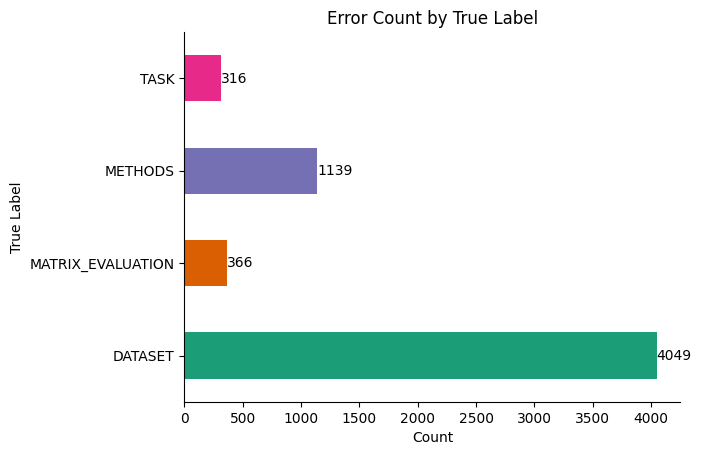

In [ ]:
label_counts = CRF_errors_df.groupby('True Label').size()
label_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

# Add the exact number next to each bar
for index, value in enumerate(label_counts):
    plt.text(value, index, str(value), va='center')  # Adds count at the end of each bar

# Beautify the plot
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('True Label')
plt.title('Error Count by True Label')

plt.show()

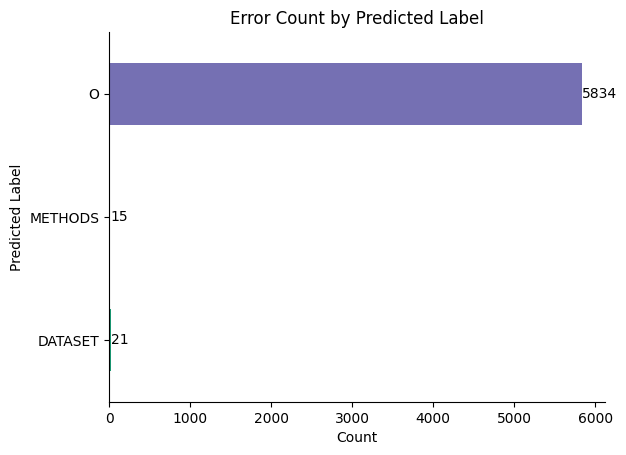

In [ ]:
label_counts = CRF_errors_df.groupby('Predicted Label').size()
label_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

# Add the exact number next to each bar
for index, value in enumerate(label_counts):
    plt.text(value, index, str(value), va='center')  # Adds count at the end of each bar

# Beautify the plot
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Predicted Label')
plt.title('Error Count by Predicted Label')

plt.show()

-data(s) that succesfully predicted by model

In [ ]:
CRF_correct_df

,Token,True Label,Predicted Label,Sentence
0,Support,METHODS,METHODS,SENTIMEN ANALISIS PUBLIK TERHADAP KEBIJAKAN L...
1,F1-Score,MATRIX_EVALUATION,MATRIX_EVALUATION,SENTIMEN ANALISIS PUBLIK TERHADAP KEBIJAKAN L...
2,Support,METHODS,METHODS,SENTIMEN ANALISIS PUBLIK TERHADAP KEBIJAKAN L...
3,Support,METHODS,METHODS,SENTIMEN ANALISIS PUBLIK TERHADAP KEBIJAKAN L...
4,mengenai,DATASET,DATASET,SENTIMEN ANALISIS PUBLIK TERHADAP KEBIJAKAN L...
...,...,...,...,...
10345,rekomendasi,TASK,TASK,Sistem Rekomendasi Content-based Filtering Men...
10346,Informatika,DATASET,DATASET,Sistem Rekomendasi Content-based Filtering Men...
10347,Universitas,DATASET,DATASET,Sistem Rekomendasi Content-based Filtering Men...
10348,Vector,METHODS,METHODS,Sistem Rekomendasi Content-based Filtering Men...


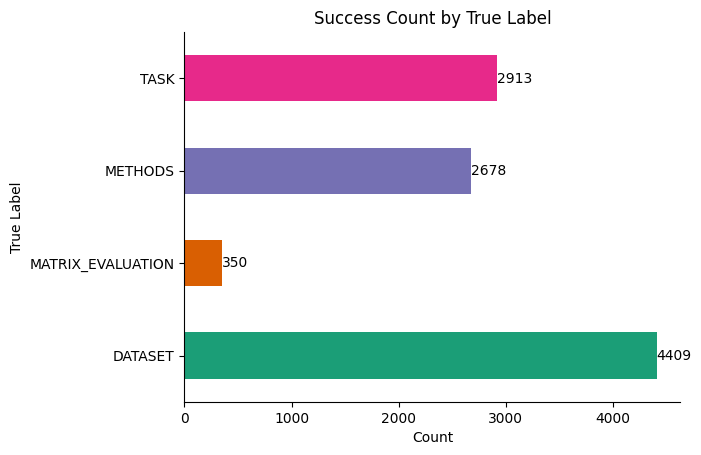

In [ ]:
label_counts = CRF_correct_df.groupby('True Label').size()
label_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

# Add the exact number next to each bar
for index, value in enumerate(label_counts):
    plt.text(value, index, str(value), va='center')  # Adds count at the end of each bar

# Beautify the plot
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('True Label')
plt.title('Success Count by True Label')

plt.show()

## HMM SECTION

IMPORT DATA

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1H5C9M7LoYX7fXdRCdIV29kACqKc1VcYV'
df = pd.read_csv(url)

FILL NAN DATA

In [ ]:
df.fillna('', inplace=True)

HMM MODEL TRAIN AND TEST

In [ ]:
class HMMNotTrainedError(Exception):
    """
    New Exception that signifies that the Hidden Markov Model (HMM)
    is not trained.
    """
    def __init__(self, message):
        self.message = message
    def __str__(self):
        return self.message


class BookkeepingHMM:
    """
    NER using HMM for entity extraction from a DataFrame column, with custom labels for 'TASK', 'DATASET', 'METHODS', and 'MATRIX_EVALUATION'.
    """

    def __init__(self):
        self.hmm_trainer = None  # stores the trained HMM trainer
        self.tagger = None  # stores the trained HMM tagger
        self.errors_df = pd.DataFrame()  # DataFrame to store errors for external access
        self.correct_df = pd.DataFrame()  # DataFrame to store correct predictions for external access

    def learn(self, df, text_column, label_columns):
        """
        Train the HMM model using a DataFrame.
        :param df: DataFrame containing the training data
        :param text_column: The column name in the DataFrame containing full text
        :param label_columns: A dictionary mapping each text token to its label
        """
        train_list = self.df_to_train_list(df, text_column, label_columns)

        # Using the HMM Trainer
        trainer = hmm.HiddenMarkovModelTrainer()
        self.tagger = trainer.train(train_list)

    def test(self, df, text_column, label_columns):
      """
      Test the trained HMM model and perform error analysis.
      :param df: DataFrame containing the test data
      :param text_column: The column name in the DataFrame containing full text
      :param label_columns: A dictionary mapping each text token to its label
      """
      if not self.tagger:
        raise HMMNotTrainedError("HMM model not trained yet.")

      test_list = self.df_to_train_list(df, text_column, label_columns)

      total_labels = []
      total_predictions = []

      # Track errors and correct predictions
      errors = []  # Stores tuples of (token, true_label, predicted_label, sentence)
      correct_preds = []  # Stores tuples of (token, true_label, predicted_label, sentence)

      # Evaluate the accuracy of the tagger
      for i, sent in enumerate(test_list):
        tokens, true_labels = zip(*sent)
        predicted_labels = [tag for _, tag in self.tagger.tag(tokens)]
        total_labels.extend(true_labels)
        total_predictions.extend(predicted_labels)

        # Record errors and correct predictions
        sentence_text = df.iloc[i][text_column]  # Original sentence for context
        for token, true_label, predicted_label in zip(tokens, true_labels, predicted_labels):
            if true_label != 'O':  # Exclude 'O' for focused error analysis
                if true_label == predicted_label:
                    correct_preds.append((token, true_label, predicted_label, sentence_text))
                else:
                    errors.append((token, true_label, predicted_label, sentence_text))

      # Filter out 'O' labels from both total_labels and total_predictions
      filtered_labels_predictions = [(label, pred) for label, pred in zip(total_labels, total_predictions) if label != 'O']
      if not filtered_labels_predictions:
        print("No non-'O' labels found for evaluation.")
        return

      # Unzip filtered pairs into separate lists
      filtered_labels, filtered_predictions = zip(*filtered_labels_predictions)

      # Define the labels to include in the report (excluding 'O')
      valid_labels = list(label_columns.keys())

      # Calculate accuracy and F1 score using sklearn.metrics
      accuracy = sum(p == l for p, l in zip(filtered_predictions, filtered_labels)) / len(filtered_labels)
      # print(f"Accuracy (excluding 'O'): {accuracy}")
      print(f"Precision (excluding 'O'): {precision_score(filtered_labels, filtered_predictions, average='weighted', zero_division=0)}")
      print(f"Recall (excluding 'O'): {recall_score(filtered_labels, filtered_predictions, average='weighted', zero_division=0)}")
      print(f"F1 Score (excluding 'O'): {f1_score(filtered_labels, filtered_predictions, average='weighted', zero_division=0)}")


      # Classification report for detailed performance on each label (excluding 'O')
      print(classification_report(filtered_labels, filtered_predictions, labels=valid_labels))

      # Save errors and correct predictions to DataFrames for external access
      self.errors_df = pd.DataFrame(errors, columns=['Token', 'True Label', 'Predicted Label', 'Sentence'])
      self.correct_df = pd.DataFrame(correct_preds, columns=['Token', 'True Label', 'Predicted Label', 'Sentence'])


    def predict_single_memo(self, sent):
        """
        Use the HMM model to label a new text.
        :param sent: The input sentence (string)
        """
        if not self.tagger:
            raise HMMNotTrainedError("HMM model not trained yet.")

        tokens = nltk.word_tokenize(sent)
        return self.tagger.tag(tokens)

    def df_to_train_list(self, df, text_column, label_columns):
        """
        Convert DataFrame to a format compatible with HMM training.
        :param df: DataFrame containing the data
        :param text_column: The column name for the full text
        :param label_columns: The column names for the labels
        :return: A list of token-label tuples
        """
        labeled_list = []
        for _, row in df.iterrows():
            tokens = nltk.word_tokenize(row[text_column])  # Tokenize text
            labels = [self.assign_label(token, row, label_columns) for token in tokens]
            labeled_list.append(list(zip(tokens, labels)))
        return labeled_list

    def assign_label(self, token, row, label_columns):
        """
        Assigns a label to the token based on the row and the label columns.
        """
        for label, col in label_columns.items():
            if isinstance(row[col], str):  # Ensure the column is a string
                if token in row[col].split():
                    return label
        return 'O'  # Default label for non-entity tokens

# Example usage with a DataFrame

# Assume df is already defined and contains the training data
B = BookkeepingHMM()
label_columns = {'TASK': 'task', 'DATASET': 'data_set', 'METHODS': 'methods', 'MATRIX_EVALUATION': 'matrix_evaluation'}
B.learn(df, 'full_text', label_columns)  # Train with the DataFrame
B.test(df, 'full_text', label_columns)  # Test with the DataFrame

# Predict for a new sentence
sentence = "Analisis Sentimen Publik berdasarkan Opini Pengguna Twitter"
print(B.predict_single_memo(sentence))

# Access errors and correct predictions DataFrames for further analysis or display
HMM_errors_df = B.errors_df
HMM_correct_df = B.correct_df

/usr/local/lib/python3.10/dist-packages/nltk/tag/hmm.py:336: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])
/usr/local/lib/python3.10/dist-packages/nltk/tag/hmm.py:332: RuntimeWarning: overflow encountered in cast
  P[i] = self._priors.logprob(si)
/usr/local/lib/python3.10/dist-packages/nltk/tag/hmm.py:334: RuntimeWarning: overflow encountered in cast
  X[i, j] = self._transitions[si].logprob(self._states[j])


Precision (excluding 'O'): 0.9945536722695224
Recall (excluding 'O'): 0.5151664611590628
F1 Score (excluding 'O'): 0.6564846575882926
                   precision    recall  f1-score   support

             TASK       1.00      0.68      0.81      3229
          DATASET       0.99      0.36      0.53      8458
          METHODS       0.99      0.78      0.87      3817
MATRIX_EVALUATION       1.00      0.18      0.31       716

        micro avg       0.99      0.52      0.68     16220
        macro avg       1.00      0.50      0.63     16220
     weighted avg       0.99      0.52      0.66     16220

[('Analisis', 'TASK'), ('Sentimen', 'TASK'), ('Publik', 'O'), ('berdasarkan', 'O'), ('Opini', 'O'), ('Pengguna', 'O'), ('Twitter', 'O')]


ERROR ANALYSIS

-data(s) that wrongly predicted by model

In [ ]:
HMM_errors_df

,Token,True Label,Predicted Label,Sentence
0,Indonesia,DATASET,O,SENTIMEN ANALISIS PUBLIK TERHADAP KEBIJAKAN L...
1,mengenai,DATASET,O,SENTIMEN ANALISIS PUBLIK TERHADAP KEBIJAKAN L...
2,Indonesia,DATASET,O,SENTIMEN ANALISIS PUBLIK TERHADAP KEBIJAKAN L...
3,mengenai,DATASET,O,SENTIMEN ANALISIS PUBLIK TERHADAP KEBIJAKAN L...
4,mengenai,DATASET,O,SENTIMEN ANALISIS PUBLIK TERHADAP KEBIJAKAN L...
...,...,...,...,...
7859,sistem,TASK,O,Sistem Rekomendasi Content-based Filtering Men...
7860,Informatika,DATASET,O,Sistem Rekomendasi Content-based Filtering Men...
7861,Universitas,DATASET,O,Sistem Rekomendasi Content-based Filtering Men...
7862,Informatika,DATASET,O,Sistem Rekomendasi Content-based Filtering Men...


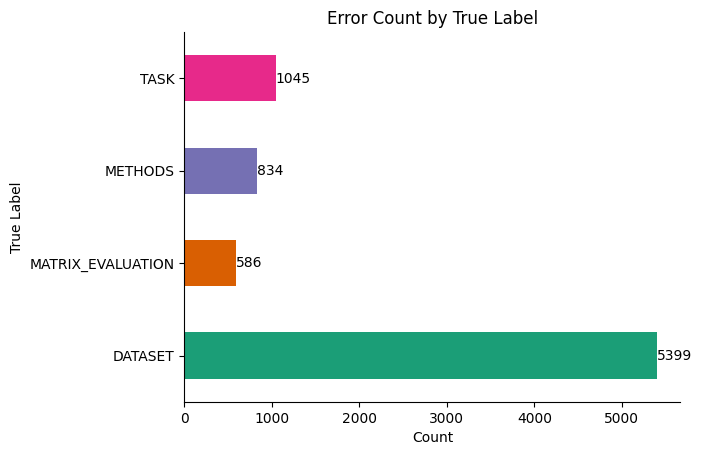

In [ ]:
label_counts = HMM_errors_df.groupby('True Label').size()
label_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

# Add the exact number next to each bar
for index, value in enumerate(label_counts):
    plt.text(value, index, str(value), va='center')  # Adds count at the end of each bar

# Beautify the plot
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('True Label')
plt.title('Error Count by True Label')

plt.show()

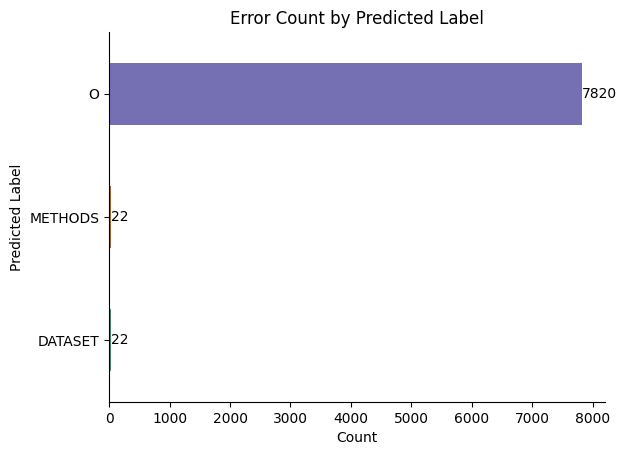

In [ ]:
label_counts = HMM_errors_df.groupby('Predicted Label').size()
label_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

# Add the exact number next to each bar
for index, value in enumerate(label_counts):
    plt.text(value, index, str(value), va='center')  # Adds count at the end of each bar

# Beautify the plot
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Predicted Label')
plt.title('Error Count by Predicted Label')

plt.show()

-data(s) that succesfully predicted by model

In [ ]:
HMM_correct_df

,Token,True Label,Predicted Label,Sentence
0,Support,METHODS,METHODS,SENTIMEN ANALISIS PUBLIK TERHADAP KEBIJAKAN L...
1,TF-IDF,METHODS,METHODS,SENTIMEN ANALISIS PUBLIK TERHADAP KEBIJAKAN L...
2,F1-Score,MATRIX_EVALUATION,MATRIX_EVALUATION,SENTIMEN ANALISIS PUBLIK TERHADAP KEBIJAKAN L...
3,Support,METHODS,METHODS,SENTIMEN ANALISIS PUBLIK TERHADAP KEBIJAKAN L...
4,Support,METHODS,METHODS,SENTIMEN ANALISIS PUBLIK TERHADAP KEBIJAKAN L...
...,...,...,...,...
8351,rekomendasi,TASK,TASK,Sistem Rekomendasi Content-based Filtering Men...
8352,rekomendasi,TASK,TASK,Sistem Rekomendasi Content-based Filtering Men...
8353,Vector,METHODS,METHODS,Sistem Rekomendasi Content-based Filtering Men...
8354,Vector,METHODS,METHODS,Sistem Rekomendasi Content-based Filtering Men...


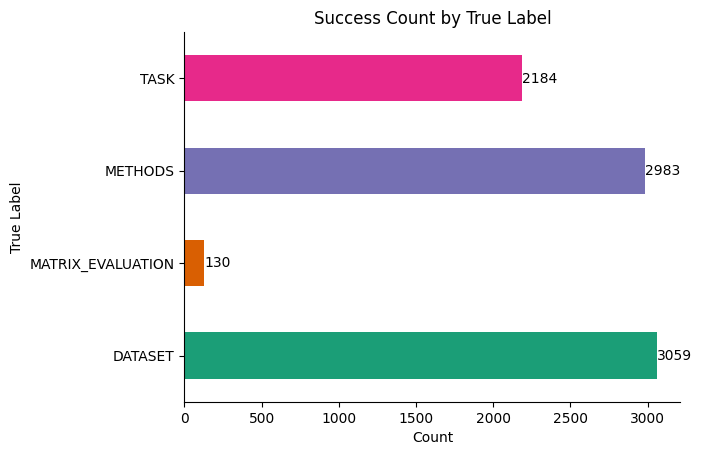

In [ ]:
label_counts = HMM_correct_df.groupby('True Label').size()
label_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

# Add the exact number next to each bar
for index, value in enumerate(label_counts):
    plt.text(value, index, str(value), va='center')  # Adds count at the end of each bar

# Beautify the plot
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('True Label')
plt.title('Success Count by True Label')

plt.show()